In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.integrate import odeint
from utils import *

# LQR Controller

In [2]:
dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum()

In [3]:
d2r = np.pi/180
r2d = 180/np.pi

In [4]:
#now make the time series
max_time = 30
freq = 10       # frequency/Hz
dt = 1.0 / freq # useful for the animation function
t = np.linspace(0, max_time, int(freq*max_time+1))

s_0 = np.array([0, 0, 2*np.pi, np.pi-20*d2r, 0, 0, 0, 0])   # Initial state.
s_star = np.array([5, 8, 2*np.pi, np.pi, 0, 0, 0, 0])       # Final state.
u_star = np.ones(dynamics.control_dim) * (dynamics.mp+dynamics.mQ) * dynamics.g/2 # Final control.

In [5]:
def calculateK(A, B, Q=None, R=None, max_iter=1000, eps=1e-8):

    state_dim, control_dim = B.shape
    
    if Q is None:
        Q = np.identity(state_dim)
    if R is None:
        R = np.identity(control_dim)
    
    P = np.zeros((A.shape[0], A.shape[0]))
    delta = eps
    i = 0
    while delta >= eps and i < max_iter:
        K = -np.linalg.inv(R+B.T@P@B)@B.T@P@A
        P_next = Q + A.T@P@(A+B@K)
        delta = np.max(np.abs(P_next-P))
        P = P_next
        i += 1
    return K

dfds = dynamics.dfds(s_star, None, u_star)
dfdu = dynamics.dfdu(s_star, None, u_star)

A = np.identity(dynamics.state_dim) + dt * dfds
B = dt * dfdu

In [6]:
K = calculateK(A, B)
K

array([[   0.3770703 ,   -0.69002861,   40.14678646, -104.50170604,
           1.0548643 ,   -3.05156747,    6.27716064,  -29.45300972],
       [  -0.3770703 ,   -0.69002861,  -40.14678646,  104.50170604,
          -1.0548643 ,   -3.05156747,   -6.27716064,   29.45300972]])

In [7]:
s2_init_list = [s_0]

#integrate dynamics output
s2_t_list = []
u_t_list = []
for s2_0 in s2_init_list:

    s = np.zeros((t.shape[0], dynamics.state_dim))
    s[0] = s2_0
    
    u = np.zeros([t.shape[0], dynamics.control_dim])
    
    for k in range(len(t)-1):
        delta_s = s[k]-s_star
        u[k] = u_star + K @ delta_s.T
        s[k+1] = odeint(dynamics, s[k], t[k: k+2], (u[k],))[1]
    s2_t_list.append(s)
    u_t_list.append(u)

In [8]:
s2_t = s2_t_list[0]
u_t = u_t_list[0]
animate_planar_quad_with_inverted_pendulum(t, s2_t[:,0], s2_t[:,1], s2_t[:,2], s2_t[:,3], display_in_notebook=True)

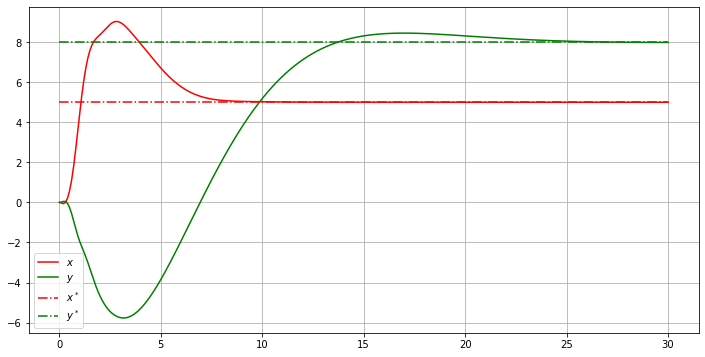

In [9]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

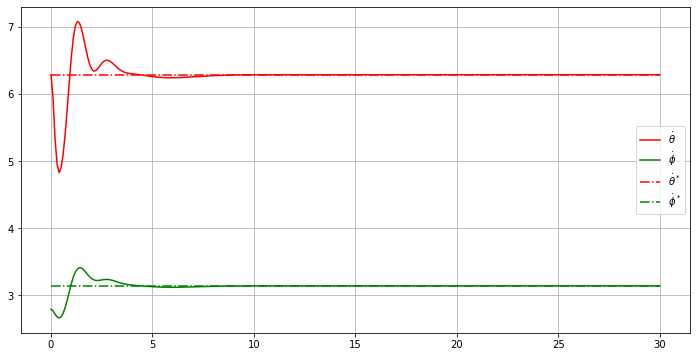

In [10]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,2],'r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[2]*np.ones_like(t),'-.r',label='$\\dot{\\theta}^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[3]*np.ones_like(t),'-.g',label='$\\dot{\\phi}^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

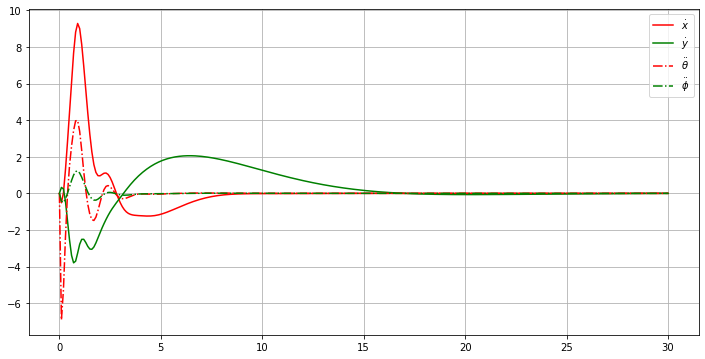

In [11]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,6],'-.r',label='$\\ddot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,7],'-.g',label='$\\ddot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

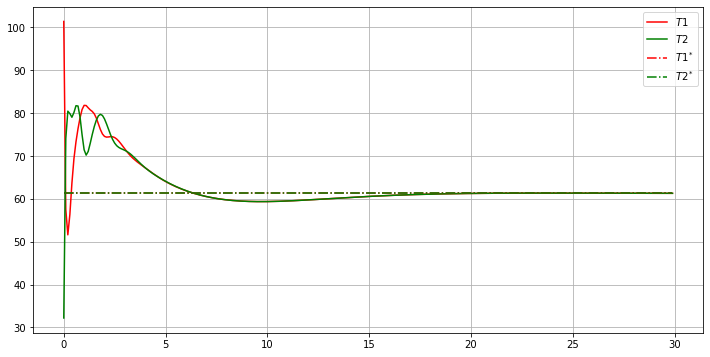

In [12]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u_t[:-1,0],'r',label='$T1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_t[:-1,1],'g',label='$T2$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here